In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings

# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour)

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)


In [ ]:
PATH='.'

In [ ]:
train_err  = pd.read_csv(PATH+'/train_err_data.csv')
display(train_err.head())

user_id            time model_nm       fwver  errtype errcode
0    10000  20201101025616  model_3  05.15.2138       15       1
1    10000  20201101030309  model_3  05.15.2138       12       1
2    10000  20201101030309  model_3  05.15.2138       11       1
3    10000  20201101050514  model_3  05.15.2138       16       1
4    10000  20201101050515  model_3  05.15.2138        4       0

In [ ]:
# 데이터 설명을 확인하면
# ueser_id가 10000부터 24999까지 총 15000개가 연속적으로 존재.
display(train_err.head())
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

user_id            time model_nm       fwver  errtype errcode
0    10000  20201101025616  model_3  05.15.2138       15       1
1    10000  20201101030309  model_3  05.15.2138       12       1
2    10000  20201101030309  model_3  05.15.2138       11       1
3    10000  20201101050514  model_3  05.15.2138       16       1
4    10000  20201101050515  model_3  05.15.2138        4       0

In [ ]:
print(np.sort(train_err.errtype.unique()))
# errtype이 1부터 42까지 29를 제외한 41개가 존재.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [ ]:
id_error = train_err[['user_id','errtype']].values
print(id_error)
error = np.zeros((train_user_number,42))  #15000,42의 어레이 형테를 0벡터로 만들고

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - train_user_id_min,err - 1] += 1

error.shape
error

  0%|          | 31879/16554663 [00:00<00:51, 318785.74it/s]

[[10000    15]
 [10000    12]
 [10000    11]
 ...
 [24999     4]
 [24999     4]
 [24999    15]]


100%|██████████| 16554663/16554663 [00:43<00:00, 382230.56it/s]


array([[  0.,   0.,   8., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ..., 113.,  56.,   1.],
       [  0.,   0.,   2., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,  58.,   8.,   5.],
       [  0.,   0.,   0., ...,   6.,   0.,   0.],
       [  0.,   0.,   4., ...,   0.,   0.,   0.]])

In [ ]:
train_err['errtype_code'] = train_err["errtype"].map(str) + " " + train_err["errcode"].map(str)
train_err

user_id            time model_nm       fwver  errtype errcode  \
0           10000  20201101025616  model_3  05.15.2138       15       1   
1           10000  20201101030309  model_3  05.15.2138       12       1   
2           10000  20201101030309  model_3  05.15.2138       11       1   
3           10000  20201101050514  model_3  05.15.2138       16       1   
4           10000  20201101050515  model_3  05.15.2138        4       0   
...           ...             ...      ...         ...      ...     ...   
16554658    24999  20201130163051  model_3  05.15.2138       15       1   
16554659    24999  20201130172625  model_3  05.15.2138       16       1   
16554660    24999  20201130172625  model_3  05.15.2138        4       0   
16554661    24999  20201130172631  model_3  05.15.2138        4       0   
16554662    24999  20201130210625  model_3  05.15.2138       15       1   

         errtype_code  
0                15 1  
1                12 1  
2                11 1  
3                16 1  
4                 4 0  
...               ...  
16554658         15 1  
16554659         16 1  
16554660          4 0  
16554661          4 0  
16554662         15 1  

[16554663 rows x 7 columns]

In [ ]:
# Null 값을 가진 샘플 제거
train_err.dropna(axis=0, inplace=True)

In [ ]:
len(train_err.errtype_code.unique())

2870

## 신재현 코드 추가 시작

## train_err errtype이 왜 26종이지...흠 41종인데

In [ ]:
len(train_err.errtype.unique())

26

In [ ]:
len(train_err.errcode.unique())

45

## 승태님 df에 맞는 시각화 버전 1

In [ ]:
train_err.errtype_code.count()

8379135

In [ ]:
items = train_err.errtype_code.unique().astype(str)
items

array(['15 1', '12 1', '11 1', ..., '38 4526', '38 3965', '38 25999'],
      dtype='<U42')

In [ ]:
train_err.errtype

0           15
7           15
12          15
16          15
20          15
            ..
16554645    15
16554650    15
16554654    15
16554658    15
16554662    15
Name: errtype, Length: 8379135, dtype: int64

## errtype_code 2870개인데 이 errocode 45개중 고르면  

In [ ]:
errtype_pick=[]
err_list=[0,8,9,10,11,12,13,14,15,16,17,19,20,21,22,23,27,28,29,30,32,33,35,36,37,45,47,48,49,51,52,54,57,58,59,94,95,99,101,115,116,117,118,119,120,121,122,124,125,1236,2783,2784,2785,2786,2787,2789,2797,2798,2813,2829,2848,2854,2855,2856,2857
]
for i in range(len(err_list)):
  a=err_list[i]
  errtype_pick.append(items[a])


In [ ]:
errtype_pick

['15 1',
 '3 1',
 '13 1',
 '3 2',
 '6 1',
 '7 1',
 '27 1',
 '28 1',
 '31 1',
 '33 2',
 '22 1',
 '41 NFANDROID2',
 '5 B-A8002',
 '14 14',
 '40 1',
 '40 0',
 '7 14',
 '37 0',
 '33 3',
 '36 8.0',
 '23 active',
 '18 1',
 '19 1',
 '21 1',
 '42 3',
 '33 1',
 '23 terminate by peer user',
 '4 1',
 '23 connection fail to establish',
 '39 1',
 '39 0',
 '17 13',
 '32 81',
 '32 86',
 '32 84',
 '5 Q-64001',
 '5 H-51042',
 '38 3113',
 '38 3674',
 '32 96',
 '32 97',
 '32 100',
 '32 105',
 '32 110',
 '32 106',
 '32 101',
 '38 3758',
 '32 76',
 '5 H-51049',
 '38 5382',
 '38 8258',
 '38 7288',
 '38 31632',
 '38 3496',
 '38 4038',
 '38 3382',
 '38 7976',
 '38 5647',
 '32 66',
 '38 5159',
 '38 3747',
 '38 7462',
 '38 4268',
 '38 4618',
 '38 6737']

In [ ]:
train_err['errtype_pick'] = train_err['errtype_code'].isin(errtype_pick).astype('int64')
train_err = train_err[train_err.errtype_pick == 1]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_err.groupby(by='errtype_pick').describe()

user_id                                                        \
                  count          mean          std      min      25%      50%   
errtype_pick                                                                    
1             8379135.0  17657.156078  4384.724805  10000.0  13962.0  17471.0   

                                     time                ...                \
                  75%      max      count          mean  ...           75%   
errtype_pick                                             ...                 
1             21432.0  24999.0  8379135.0  2.020112e+13  ...  2.020112e+13   

                              errtype                                        \
                       max      count       mean       std  min   25%   50%   
errtype_pick                                                                  
1             2.020120e+13  8379135.0  22.346499  10.13041  3.0  15.0  22.0   

                          
               75%   max  
errtype_pick              
1             31.0  42.0  

[1 rows x 24 columns]

In [ ]:
train_err.columns

Index(['user_id', 'time', 'model_nm', 'fwver', 'errtype', 'errcode',
       'errtype_code', 'errtype_pick'],
      dtype='object')

<AxesSubplot:>

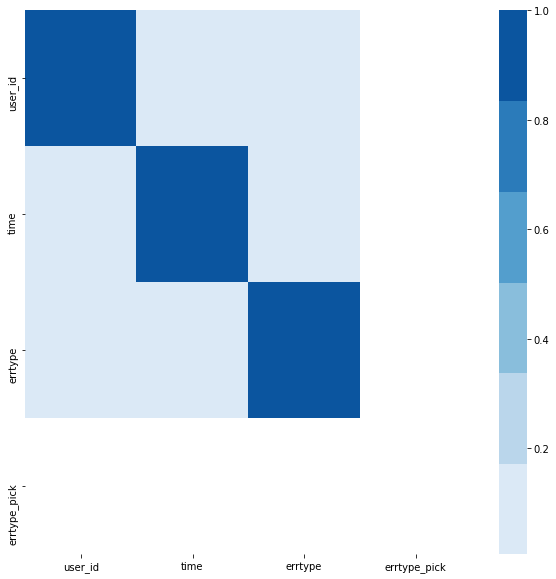

In [ ]:
import seaborn as sns

corr = train_err.corr()
cmap = sns.color_palette("Blues")
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap=cmap)

In [ ]:
train_err.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8379135 entries, 0 to 16554662
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       int64 
 1   time          int64 
 2   model_nm      object
 3   fwver         object
 4   errtype       int64 
 5   errcode       object
 6   errtype_code  object
 7   errtype_pick  int64 
dtypes: int64(4), object(4)
memory usage: 575.3+ MB


In [ ]:
train_err.errtype_pick.value_counts()

1    8379135
Name: errtype_pick, dtype: int64

In [ ]:
train_err.errtype_code.value_counts()

22 1         1865361
15 1         1604951
31 1          968650
5 B-A8002     897863
28 1          544306
              ...   
38 3758            1
38 3496            1
38 7976            1
38 4038            1
38 5159            1
Name: errtype_code, Length: 65, dtype: int64

In [ ]:
train_err_group = train_err.groupby(['errtype', 'errcode']).count().reset_index()
train_err_group = train_err_group.reset_index()
train_err_group.rename(columns = {'index' : 'group_index'}, inplace=True)
train_err_group

group_index  errtype     errcode  user_id    time  model_nm   fwver  \
0             0        3           1    26902   26902     26902   26902   
1             1        3           2     3733    3733      3733    3733   
2             2        4           1   121158  121158    121158  121158   
3             3        5     B-A8002   897863  897863    897863  897863   
4             4        5     H-51042     1045    1045      1045    1045   
..          ...      ...         ...      ...     ...       ...     ...   
60           60       39           1     8149    8149      8149    8149   
61           61       40           0   355729  355729    355729  355729   
62           62       40           1   374649  374649    374649  374649   
63           63       41  NFANDROID2   104138  104138    104138  104138   
64           64       42           3    33676   33676     33676   33676   

    errtype_code  errtype_pick  
0          26902         26902  
1           3733          3733  
2         121158        121158  
3         897863        897863  
4           1045          1045  
..           ...           ...  
60          8149          8149  
61        355729        355729  
62        374649        374649  
63        104138        104138  
64         33676         33676  

[65 rows x 9 columns]

<AxesSubplot:>

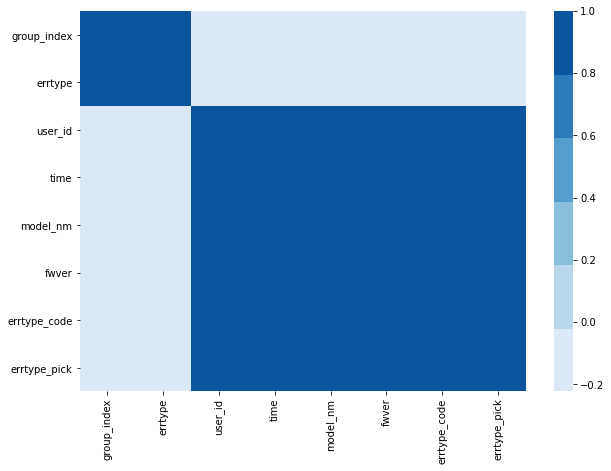

In [ ]:
import seaborn as sns

corr = train_err_group.corr()
cmap = sns.color_palette("Blues")
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, cmap=cmap)

## 시각화 끝

In [ ]:
train_err_group['errtype_code'] =  train_err_group["errtype"].map(str) +" "+ train_err_group["errcode"]
train_err_group

group_index  errtype     errcode  ...   fwver   errtype_code  errtype_pick
0             0        3           1  ...   26902            3 1         26902
1             1        3           2  ...    3733            3 2          3733
2             2        4           1  ...  121158            4 1        121158
3             3        5     B-A8002  ...  897863      5 B-A8002        897863
4             4        5     H-51042  ...    1045      5 H-51042          1045
..          ...      ...         ...  ...     ...            ...           ...
60           60       39           1  ...    8149           39 1          8149
61           61       40           0  ...  355729           40 0        355729
62           62       40           1  ...  374649           40 1        374649
63           63       41  NFANDROID2  ...  104138  41 NFANDROID2        104138
64           64       42           3  ...   33676           42 3         33676

[65 rows x 9 columns]

In [ ]:
train_err['errtype_code'] =  train_err["errtype"].map(str) +" "+ train_err["errcode"].map(str)

In [ ]:
train_err_merge = pd.merge(train_err, train_err_group[['errtype_code', 'group_index']], how='inner', on ='errtype_code')

In [ ]:
train_err_merge

user_id            time  ... errtype_pick group_index
0          10000  20201101025616  ...            1          13
1          10000  20201101060903  ...            1          13
2          10000  20201102005521  ...            1          13
3          10000  20201102060831  ...            1          13
4          10000  20201103025616  ...            1          13
...          ...             ...  ...          ...         ...
8379130    24889  20201102191146  ...            1          58
8379131    24909  20201108090017  ...            1          51
8379132    24909  20201108090056  ...            1          53
8379133    24909  20201111064800  ...            1          56
8379134    24909  20201116135026  ...            1          52

[8379135 rows x 9 columns]

In [ ]:
# user_id와 errtype만을 사용하여 데이터 셋 생성
# 모든 일자에 대해서 errtype별 발생 건수를 count
# pandas의 groupby를 활용할 경우 큰 연산 자원이 필요.
# numpy로 placeholder를 만들어 구현함.
id_error = train_err_merge[['user_id','group_index']].values
print(id_error)
errorc = np.zeros((train_user_number,65))  #15000,42의 어레이 형테를 0벡터로 만들고

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    errorc[person_idx - train_user_id_min, err ] += 1

errorc.shape
errorc

  0%|          | 23723/8379135 [00:00<00:35, 237224.00it/s]

[[10000    13]
 [10000    13]
 [10000    13]
 ...
 [24909    53]
 [24909    56]
 [24909    52]]


100%|██████████| 8379135/8379135 [00:32<00:00, 257010.13it/s]


array([[ 7.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 57., 56.,  1.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  1., ..., 29.,  8.,  5.],
       [ 0.,  0.,  0., ...,  3.,  0.,  0.],
       [ 0.,  4.,  0., ...,  0.,  0.,  0.]])

In [ ]:
train_prob = pd.read_csv(PATH+'/train_problem_data.csv')
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0
problem[train_prob.user_id.unique()-10000] = 1 
problem.shape

(15000,)

In [ ]:
print(error.shape)
print(errorc.shape)
error=np.concatenate((error.T, errorc.T), axis=0)
error=error.T
print(error.shape)

(15000, 42)
(15000, 65)
(15000, 107)


In [ ]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y

train_x = error
train_y = problem
#del error, problem
print(train_x.shape)
print(train_y.shape)

(15000, 107)
(15000,)


In [ ]:
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------
models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015
                }
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 2000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 100
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.807405	valid_0's pr_auc: 0.801835
[40]	valid_0's auc: 0.809727	valid_0's pr_auc: 0.805999
[60]	valid_0's auc: 0.808583	valid_0's pr_auc: 0.805325
[80]	valid_0's auc: 0.808261	valid_0's pr_auc: 0.805705
[100]	valid_0's auc: 0.808496	valid_0's pr_auc: 0.804901
[120]	valid_0's auc: 0.807312	valid_0's pr_auc: 0.804253
Early stopping, best iteration is:
[26]	valid_0's auc: 0.810581	valid_0's pr_auc: 0.80645
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.813886	valid_0's pr_auc: 0.340456
[40]	valid_0's auc: 0.81489	valid_0's pr_auc: 0.362495
[60]	valid_0's auc: 0.815222	valid_0's pr_auc: 0.373983
[80]	valid_0's auc: 0.81243	valid_0's pr_auc: 0.378805
[100]	valid_0's auc: 0.812847	valid_0's pr_auc: 0.368183
Early stopping, best iteration is:
[11]	valid_0's auc: 0.809172	valid_0's pr_auc: 0.38553
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's

In [ ]:
print(np.mean(auc_scores))

0.8132268368011282


0.8019594286352891

0.7915834292563759


0.7982904396441357


#제출 파일 생성

In [ ]:
test_err  = pd.read_csv(PATH+'/test_err_data.csv')
display(test_err.head())

user_id            time model_nm       fwver  errtype errcode
0    30000  20201101030227  model_1  04.16.3553       31       1
1    30000  20201101030227  model_1  04.16.3553       33       2
2    30000  20201101030228  model_1  04.16.3553       15       1
3    30000  20201101030256  model_1  04.16.3553       22       1
4    30000  20201101030300  model_1  04.16.3553       11       1

In [ ]:
# 데이터 설명을 확인하면
# test 데이터는 ueser_id가 30000부터 44998까지 총 14999개가 존재.
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [ ]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)


100%|██████████| 16532648/16532648 [01:11<00:00, 231638.65it/s]


In [ ]:
print(test_x.shape)

(14999, 42)


In [ ]:
test_err['errtype_code'] = test_err["errtype"].map(str) + " " + test_err["errcode"].map(str)
test_err

user_id            time model_nm  ... errtype  errcode errtype_code
0           30000  20201101030227  model_1  ...      31        1         31 1
1           30000  20201101030227  model_1  ...      33        2         33 2
2           30000  20201101030228  model_1  ...      15        1         15 1
3           30000  20201101030256  model_1  ...      22        1         22 1
4           30000  20201101030300  model_1  ...      11        1         11 1
...           ...             ...      ...  ...     ...      ...          ...
16532643    44998  20201130210050  model_1  ...      40        0         40 0
16532644    44998  20201130211831  model_1  ...      31        1         31 1
16532645    44998  20201130211832  model_1  ...      15        1         15 1
16532646    44998  20201130212259  model_1  ...      16        1         16 1
16532647    44998  20201130212316  model_1  ...      31        0         31 0

[16532648 rows x 7 columns]

In [ ]:
# Null 값을 가진 샘플 제거
test_err.dropna(axis=0, inplace=True)

In [ ]:
len(test_err.errtype_code.unique())


3021

In [ ]:
test_err['errtype_pick'] = test_err['errtype_code'].isin(errtype_pick).astype('int64')
test_err = test_err[test_err.errtype_pick == 1]

In [ ]:
test_err_group = test_err.groupby(['errtype', 'errcode']).count().reset_index()
test_err_group = test_err_group.reset_index()
test_err_group.rename(columns = {'index' : 'group_index'}, inplace=True)
test_err_group

In [ ]:
test_err_group['errtype_code'] =  test_err_group["errtype"].map(str) +" "+ test_err_group["errcode"]
test_err_group


In [ ]:
test_err['errtype_code'] =  test_err["errtype"].map(str) +" "+ test_err["errcode"].map(str)

In [ ]:
test_err_merge = pd.merge(test_err, test_err_group[['errtype_code', 'group_index']], how='inner', on ='errtype_code')

In [ ]:
# user_id와 errtype만을 사용하여 데이터 셋 생성
# 모든 일자에 대해서 errtype별 발생 건수를 count
# pandas의 groupby를 활용할 경우 큰 연산 자원이 필요.
# numpy로 placeholder를 만들어 구현함.
id_error = test_err_merge[['user_id','group_index']].values
print(id_error)
test_xc = np.zeros((test_user_number,65))  #15000,42의 어레이 형테를 0벡터로 만들고

for person_idx, err in tqdm(id_error):
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_xc[person_idx - test_user_id_min, err ] += 1

test_xc.shape
test_xc

  0%|          | 25956/8226126 [00:00<00:31, 259555.92it/s]

[[30000    24]
 [30000    24]
 [30000    24]
 ...
 [38778    43]
 [39448    45]
 [40470    44]]


100%|██████████| 8226126/8226126 [00:31<00:00, 261884.40it/s]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.]])

In [ ]:
print(test_x.shape)
print(test_xc.shape)


(14999, 42)
(14999, 65)


In [ ]:
test_x=np.concatenate((test_x.T, test_xc.T), axis=0)
test_x=test_x.T
print(test_x.shape)

(14999, 107)


In [ ]:
# 예측
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [ ]:
pred_ensemble

array([[0.82393547],
       [0.21103977],
       [0.49417179],
       ...,
       [0.59307841],
       [0.78479284],
       [0.30409222]])

In [ ]:
sample_submssion = pd.read_csv(PATH+'/sample_submission.csv')

In [ ]:
sample_submssion['problem'] = pred_ensemble.reshape(-1)

In [ ]:
sample_submssion.to_csv(PATH+"/주요변수추출및타입별.csv", index = False)
sample_submssion

user_id   problem
0        30000  0.823935
1        30001  0.211040
2        30002  0.494172
3        30003  0.679304
4        30004  0.555845
...        ...       ...
14994    44994  0.205855
14995    44995  0.301683
14996    44996  0.593078
14997    44997  0.784793
14998    44998  0.304092

[14999 rows x 2 columns]